In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


data = pd.read_csv('schools_data.csv')
data.shape

## Pravimo kopiju podataka da ne pokvarimo originalne podatke
work_data = data.copy()
work_data.sample(5)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,repeated,data_perimeter
6858,GP,M,17,Urban,>3,Married,3,1,services,other,other,mother,1,2,0,False,False,True,True,True,True,True,True,5,4,4,3,4,5,2,0,train
4316,LT,F,16,Urban,>3,Married,2,2,other,other,reputation,mother,1,4,0,False,False,True,False,True,True,True,True,5,2,3,1,3,3,0,0,train
3519,RC,F,18,Urban,>3,Married,2,3,at_home,services,course,father,2,1,0,False,True,True,False,True,True,True,True,5,2,3,1,2,4,0,1,train
5827,GP,M,16,Urban,>3,Married,3,2,other,other,home,mother,1,1,0,False,True,True,False,False,True,True,False,5,4,3,1,1,5,0,0,validation
4188,LT,F,17,Urban,>3,Divorced,2,2,at_home,at_home,home,father,1,2,1,False,True,False,False,True,True,True,True,3,3,1,1,2,4,0,0,train


In [17]:
import seaborn as sns

Kako varijable 'famsup','freetime','absences' u eksploatornoj analizi nisu pokazali statističku značajnost u utjecaju na povaljanje godine. 

In [3]:
work_data = work_data.drop(['famsup','freetime','absences'],axis = 1)

In [4]:
work_data.sample(5)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,paid,activities,nursery,higher,internet,romantic,famrel,goout,Dalc,Walc,health,repeated,data_perimeter
2751,RC,F,16,Rural,>3,Married,3,3,services,other,reputation,father,1,3,1,True,False,True,True,True,True,False,4,2,1,1,2,1,train
604,MS,F,18,Urban,>3,Married,2,1,other,other,course,other,2,3,0,False,True,False,False,True,True,True,4,4,1,1,3,0,validation
6465,GP,M,19,Urban,>3,Married,1,2,other,services,course,other,1,2,1,False,False,False,False,True,True,False,4,2,2,2,4,0,validation
6796,GP,F,16,Rural,>3,Married,2,2,services,services,reputation,mother,2,4,0,False,True,True,False,True,True,False,5,5,1,1,5,0,train
940,MS,M,17,Urban,>3,Married,3,3,services,services,other,mother,1,2,0,False,False,True,True,True,True,True,4,4,2,3,4,0,validation


Idući koraci su varijable koje imaju dvije kategorije ćemo staviti 1 i 0 kao oznake, varijable TRUE i FALSE također na 1 i 0, te travel/study time, Medu i Fedu ćemo označiti kategorijalno. 

In [ ]:
work_data['sex'][work_data['sex'] == 'M'] = 1
work_data['sex'][work_data['sex'] == 'F'] = 0

work_data['address'][work_data['address'] == 'Urban'] = 1
work_data['address'][work_data['address'] == 'Rural'] = 0

work_data['famsize'][work_data['famsize'] == '>3'] = 1
work_data['famsize'][work_data['famsize'] == '<=3'] = 0

work_data['Pstatus'][work_data['Pstatus'] == 'Married'] = 1
work_data['Pstatus'][work_data['Pstatus'] == 'Divorced'] = 0

TFlist = ['schoolsup','paid','activities','nursery','higher','internet','romantic']
work_data[TFlist] = work_data[TFlist]*1

work_data['traveltime'][work_data['traveltime'] == 1] = '<15'
work_data['traveltime'][work_data['traveltime'] == 2] = '15-30'
work_data['traveltime'][work_data['traveltime'] == 3] = '30-60'
work_data['traveltime'][work_data['traveltime'] == 4] = '>60'

work_data['studytime'][work_data['studytime'] == 1] = '<2'
work_data['studytime'][work_data['studytime'] == 2] = '2-5'
work_data['studytime'][work_data['studytime'] == 3] = '5-10'
work_data['studytime'][work_data['studytime'] == 4] = '>10'

work_data['Medu'][work_data['Medu'] == 0] = 'none'
work_data['Medu'][work_data['Medu'] == 1] = '4th_grade'
work_data['Medu'][work_data['Medu'] == 2] = '5th-9th_grade'
work_data['Medu'][work_data['Medu'] == 3] = 'secondary_education'
work_data['Medu'][work_data['Medu'] == 4] = 'higher_education'

work_data['Fedu'][work_data['Fedu'] == 0] = 'none'
work_data['Fedu'][work_data['Fedu'] == 1] = '4th_grade'
work_data['Fedu'][work_data['Fedu'] == 2] = '5th-9th_grade'
work_data['Fedu'][work_data['Fedu'] == 3] = 'secondary_education'
work_data['Fedu'][work_data['Fedu'] == 4] = 'higher_education'

Numeričke varijable ćemo sklalirani na $[0,1]$, a kategorijalne sa $>2$ kategorije ćemo napraviti **one-hot**. 

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train = work_data[work_data['data_perimeter'] == 'train']
X_test = work_data[work_data['data_perimeter'] == 'validation']

y_train = X_train['repeated'].values
y_test = X_test['repeated'].values

X_train = X_train.drop(['data_perimeter'],axis=1)
X_test = X_test.drop(['data_perimeter'],axis=1)

X_train = X_train.drop(['repeated'],axis=1)
X_test = X_test.drop(['repeated'],axis=1)

X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pd.DataFrame(X_test).sample(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
2208,0.428571,0.000000,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.50,0.00,0.50,0.75,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2236,0.000000,0.000000,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.50,0.00,0.00,1.00,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
615,0.285714,0.000000,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.5,0.25,0.25,0.25,0.50,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
178,0.428571,0.333333,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.5,1.00,0.25,1.00,1.00,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1827,0.428571,0.000000,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.75,0.00,0.00,0.00,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [34]:
X_test.shape

(2355, 61)

Kako smo u EDA vidjeli da je odnos zavisne varijable $70:30$ napravit ćemo oversampling kako bi povećali točnost modela i povećali broj uzoraka za treniranje. Koristit ćemo algoritam $SMOTE$. 

In [ ]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

Koristit ćemo 4 ML algoritma:

1. Logistička regresija

2. Stablo odlučivanja

3. SVM Klasifikator

4. Neuronska mreža

**1. Logistička regresija**

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score

In [9]:
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2','l1','elasticnet’']
c_values = [100, 10, 1.0, 0.1, 0.01]

In [10]:
grid = dict(solver=solvers,
            penalty=penalty,
            C=c_values)

cv = RepeatedStratifiedKFold(n_splits=10, 
                             n_repeats=1, 
                             random_state=1)

grid_search = GridSearchCV(estimator=model, 
                           param_grid=grid, 
                           n_jobs=-1, 
                           cv=cv, 
                           scoring='accuracy',
                           error_score=0)

grid_result = grid_search.fit(X_train, y_train)

In [11]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.831157 using {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}


In [12]:
y_pred = grid_search.predict(X_test)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm)

[[1307  295]
 [ 142  611]]


In [13]:
acc = (cm[0][0]+cm[1][1])/2355
print('Test Accuracy:',acc)
print('Test F1: ',f1_score(y_test, y_pred))
print('Test Precision ',precision_score(y_test, y_pred))
print('Test Recal: ',recall_score(y_test, y_pred))

Test Accuracy: 0.8144373673036094
Test F1:  0.7365883062085594
Test Precision  0.67439293598234
Test Recal:  0.8114209827357237


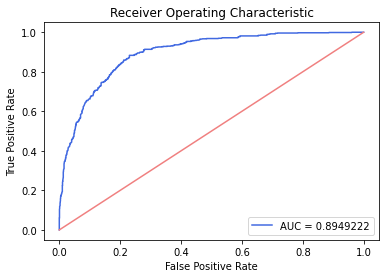

In [14]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
y_prob = grid_search.predict_proba(X_test)
          
fpr, tpr, threshold = roc_curve(y_test, y_prob[:,1])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'royalblue', label = 'AUC = %0.7f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'lightcoral')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**2. Stablo odlučivanja**

In [15]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
criterion = ['gini','entropy']
max_depth = range(1,10)
min_samples_split = range(1,10)
min_samples_leaf = range(1,5)

In [16]:
grid = dict(criterion = criterion, 
            max_depth = max_depth,
            min_samples_split = min_samples_split,
            min_samples_leaf = min_samples_leaf)

cv = RepeatedStratifiedKFold(n_splits=10, 
                             n_repeats=3, 
                             random_state=1)

grid_search = GridSearchCV(estimator=model, 
                           param_grid=grid, 
                           n_jobs=-1, 
                           cv=cv, 
                           scoring='accuracy',
                           error_score=0)

grid_result = grid_search.fit(X_train, y_train)

In [18]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.880612 using {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 3, 'min_samples_split': 6}


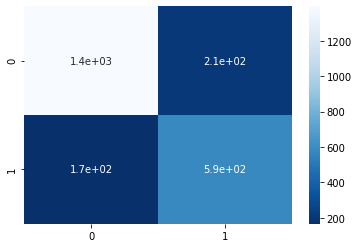

In [25]:
y_pred = grid_search.predict(X_test)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True,cmap='Blues_r')

In [26]:
acc = (cm[0][0]+cm[1][1])/2355
print('Test Accuracy:',acc)
print('Test F1: ',f1_score(y_test, y_pred))
print('Test Precision ',precision_score(y_test, y_pred))
print('Test Recal: ',recall_score(y_test, y_pred))

Test Accuracy: 0.8416135881104034
Test F1:  0.7588881706528766
Test Precision  0.739294710327456
Test Recal:  0.7795484727755644


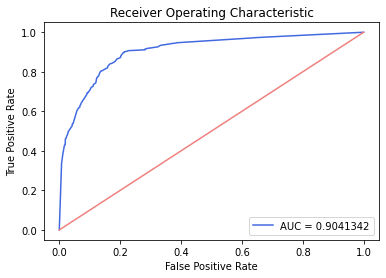

In [27]:
y_prob = grid_search.predict_proba(X_test)
          
fpr, tpr, threshold = roc_curve(y_test, y_prob[:,1])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'royalblue', label = 'AUC = %0.7f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'lightcoral')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**3. Support vector machine klasifikator**

In [28]:
from sklearn.svm import SVC

model = SVC(probability=True)
kernel = ['poly', 'rbf', 'sigmoid']
C = [100, 50, 10, 1.0, 0.1, 0.01]
gamma = ['scale']

In [29]:
grid = dict(kernel=kernel,
            C=C,gamma=gamma)

cv = RepeatedStratifiedKFold(n_splits=3, 
                             n_repeats=1, 
                             random_state=1)

grid_search = GridSearchCV(estimator=model, 
                           param_grid=grid, 
                           n_jobs=2, 
                           cv=cv, 
                           scoring='accuracy',
                           error_score=0)

grid_result = grid_search.fit(X_train, y_train)

In [30]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.897081 using {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}


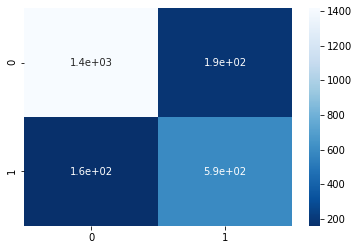

In [31]:
y_pred = grid_search.predict(X_test)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True,cmap='Blues_r')

In [32]:
acc = (cm[0][0]+cm[1][1])/2355
print('Test Accuracy:',acc)
print('Test F1: ',f1_score(y_test, y_pred))
print('Test Precision ',precision_score(y_test, y_pred))
print('Test Recal: ',recall_score(y_test, y_pred))

Test Accuracy: 0.8535031847133758
Test F1:  0.7749510763209393
Test Precision  0.7615384615384615
Test Recal:  0.7888446215139442


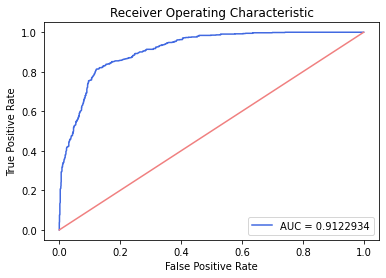

In [33]:
y_prob = grid_search.predict_proba(X_test)
          
fpr, tpr, threshold = roc_curve(y_test, y_prob[:,1])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'royalblue', label = 'AUC = %0.7f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'lightcoral')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**4. Neuronska mreža**

In [35]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier

In [36]:
def create_model(init_mode='uniform',dropout_rate=0.0,optimizer='adam'):
  model = Sequential()
  model.add(Dense(61, input_dim= 61, kernel_initializer = init_mode, activation = 'relu'))
  model.add(Dropout(dropout_rate))
  model.add(Dense(40, kernel_initializer = init_mode, activation = 'relu'))
  model.add(Dropout(dropout_rate))
  model.add(Dense(21, kernel_initializer = init_mode, activation = 'relu'))
  model.add(Dropout(dropout_rate))
  model.add(Dense(1, activation = 'sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model

In [37]:
init_mode = ['uniform', 'normal',]
dropout_rate = [0.0, 0.1, 0.15]
optimizer = ['SGD', 'RMSprop', 'Adam']

In [38]:
model = KerasClassifier(build_fn = create_model, 
                        epochs=20, 
                        batch_size=10, 
                        verbose=0)

In [39]:
param_grid = dict(dropout_rate=dropout_rate, 
                  init_mode=init_mode,
                  optimizer=optimizer)

grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid, 
                    n_jobs=-1, 
                    cv=3,
                    scoring='accuracy')

grid_result = grid.fit(X_train, y_train)

In [40]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.614695 using {'dropout_rate': 0.0, 'init_mode': 'normal', 'optimizer': 'SGD'}


Obzirom na malo sumnjiv postotak točnosti od $61\%$ ručno ćemo trenirat neuronsku mrežu s parametrima koje je Grid pronašao kao najbolje. 

In [41]:
model = Sequential()
model.add(Dense(61, input_dim= 61, kernel_initializer = 'normal', activation = 'relu'))
model.add(Dropout(0.0))
model.add(Dense(40, kernel_initializer = 'normal', activation = 'relu'))
model.add(Dropout(0.0))
model.add(Dense(21, kernel_initializer = 'normal', activation = 'relu'))
model.add(Dropout(0.0))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [42]:
model.fit(X_train, y_train,
          epochs = 20,
          verbose = 0) 

In [44]:
print(model.evaluate(X_train,y_train))
print(model.evaluate(X_test,y_test))

245/245 [==============================] - 0s 980us/step - loss: 0.2076 - accuracy: 0.9095
[0.207638218998909, 0.9094982147216797]
74/74 [==============================] - 0s 991us/step - loss: 0.3700 - accuracy: 0.8493
[0.36995306611061096, 0.8492568731307983]


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


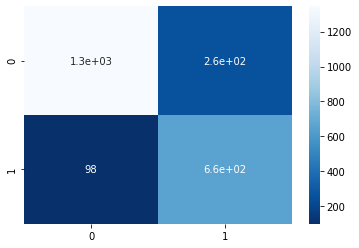

In [45]:
y_pred = model.predict_classes(X_test)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True,cmap='Blues_r')

In [46]:
acc = (cm[0][0]+cm[1][1])/2355
print('Test Accuracy:',acc)
print('Test F1: ',f1_score(y_test, y_pred))
print('Test Precision ',precision_score(y_test, y_pred))
print('Test Recal: ',recall_score(y_test, y_pred))

Test Accuracy: 0.8492569002123143
Test F1:  0.7867867867867867
Test Precision  0.7182017543859649
Test Recal:  0.8698539176626826


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


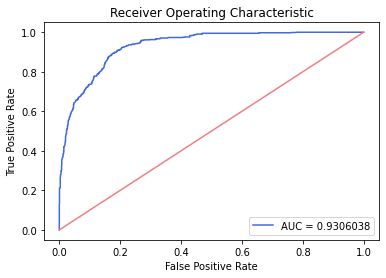

In [47]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
y_prob = model.predict_proba(X_test)
          
fpr, tpr, threshold = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'royalblue', label = 'AUC = %0.7f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'lightcoral')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Odabir modela? Pogledajmo tablicu (koja je napravljena u Excelu radi bolje preglednosti) kako koji model stoji s pojedinom performansom.

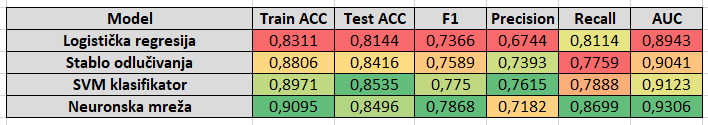

Odmah je uočljivo kako logistička regresija stoji najgore po skoro svim performansama. Za odabir najboljeg upotrijebit ćemo neki sustav bodovanja. Kako smo imali 4 modela, za svaku perfomansu ćemo modelu dodjeliti bod, tako je 1-najgore, 4-najbolje, te tako pozbrajati redom i dobiti konačan odabir. Bodovi s kumulativnim zbrojem nalaze se u tablici ispod.

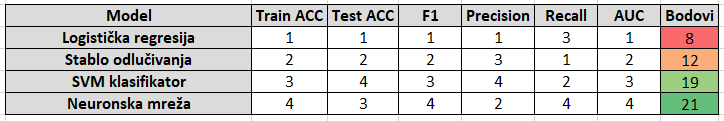

Kako je vidljivo bilo iz prve tablice, tako jednako i iz druge, najboljim modelo ćemo smatrati **Neuronsku mrežu**.

school
GP    0.328937
LT    0.371077
MS    0.334254
RC    0.313978
Name: failures, dtype: float64


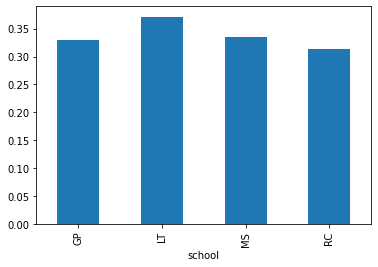

In [48]:
padovi = data.groupby('school')['failures'].mean()
print(padovi)
padovi.plot(kind='bar')
plt.show()

Izračun i grafički prikaz pokazuju da $LT$ škola u prosjeku ima najveći prosječni broj padova iz predmeta.

In [49]:
c = 'age, Medu, Fedu, traveltime, studytime, failures, famrel, freetime, goout, Dalc, Walc, health, absences, repeated'
L = c.split(", ")
pcadata = data[L]
pcadata.shape[1]

14

In [50]:
from sklearn.decomposition import PCA

pca = PCA(n_components=14)
pca.fit_transform(pcadata)

array([[-5.82154948, -1.26901567, -0.59299775, ...,  0.56376258,
         0.11063324,  0.12563076],
       [-3.79262267, -1.70926493, -1.63581198, ..., -0.06286818,
         0.01953816,  0.15696929],
       [ 1.24342587, -1.39408649, -1.94168865, ...,  0.56241053,
         0.07889439,  0.16912132],
       ...,
       [ 2.36728135,  2.58510056, -3.18547285, ..., -0.20520661,
         0.71207002,  0.11200066],
       [-5.74680457, -0.84363387, -1.44626563, ...,  1.76233067,
        -0.19923335,  0.92541783],
       [-5.79242234,  0.12516436,  1.18133803, ..., -0.16216994,
         0.06363859, -0.67658962]])

In [51]:
x = []
for i in range(14):
  s = 'PCA' + str(i+1)
  x.append(s)

y = pca.explained_variance_

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


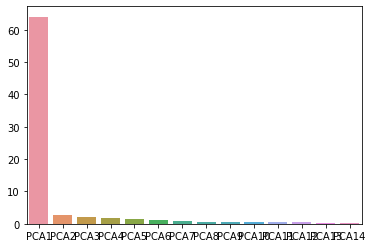

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


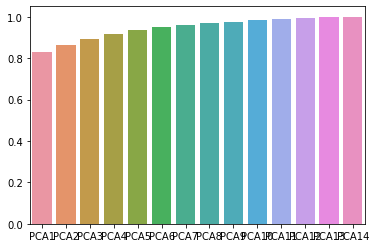

In [52]:
sns.barplot(x,y)
plt.show()
sns.barplot(x,pca.explained_variance_ratio_.cumsum())
plt.show()

In [53]:
pca.explained_variance_ratio_.cumsum()

array([0.82862822, 0.86397679, 0.8921883 , 0.91723158, 0.93479357,
       0.94917052, 0.95950681, 0.96844031, 0.97651806, 0.982592  ,
       0.98836803, 0.99370732, 0.99791067, 1.        ])

Iz grafa i navedenog niza kumulativnih suma, može se zaključiti da je potrebno 2 komplonente PCA za objašnjene barem  85%  varijance.